# OIUTILS example #1: Alpha Cen A (VLTI/PIONIER)

In this example, we look a basic interferometric data with the goal of estimating an angular diameter. The data set is from [Kervalla et al. A&A 597, 137 (2017)](https://ui.adsabs.harvard.edu/abs/2017A%26A...597A.137K/abstract): observations of Alpha Cen A with the PIONIER beam combiner. The data have very little spectral resolution and will be treated as monochromatic. Data obtained from [JMMC OIDB](http://oidb.jmmc.fr/search.html?conesearch=alpha%20cen%20%2CJ2000%2C2%2Carcmin&instrument=PIONIER&order=%5Etarget_name), except date 2016-05-28, for which V2 is too high compared to other data.

### This example covers:
- Loading multiple oifits files
- Displaying all data in a same plot
- Least square fit:
    + uniform disk diameter
    + diameter with fixed center-to-limb darkening (Claret 4 parameters)
    + diameter and adjusted center-to-limb darkening (power law)
- Better uncertainties estimates with bootstrapping

*Antoine Mérand (amerand@eso.org) 2020/04/28*

In [1]:
%pylab notebook
import os
try:
    # -- use global installation
    from oiutils import oifits, oimodels
except:
    # -- use local installation
    import sys
    sys.path = ['../oiutils'] + sys.path
    import dpfit, oifits, oimodels

Populating the interactive namespace from numpy and matplotlib


## Load Data
`oifits.loadOI` loads a single file of a list of files. Each file's data are stored in a dict. In the case below, it return a list of dict (one for each file). To optimize computation, it is a good idea to group data with the same wavelength vector. This is what `oifits.mergeOI` does, by taking the result from `oifits.loadOI` and returns a list of fewers dictionnary, but each have a unique wavelength vector. Since PIONIER spectral calibration is redone every now and then, we get fewer instances, but not a single one.

Note that the variables `data` and `merged` are echangeable in the following example.

In [2]:
directory = './AlphaCenA/'
files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.fits')]
data = oifits.loadOI(files)

# -- merging data
merged = oifits.mergeOI(data)
print('\n', len(data), 'data files merged into', len(merged), 'dictionnaries with unique setups:')
for m in merged:
    print(m['insname'], m['WL'])
    print(' \n'.join(m['filename'].split(';')))

loadOI: loading ./AlphaCenA/PIONI.2016-05-31T04_39_53.560_oidataCalibrated.fits
  > insname: "PIONIER_Pnat(1.5180295/1.7625230)" targname: "Alpha_Cen_A"
  > MJD: [57539.19623458728]
  > D0-G2-J3-K0 | WL: (6,) 1.518 to 1.763 um | ['OI_T3', 'OI_VIS2'] | TELLURICS: False
loadOI: loading ./AlphaCenA/20160523_AlphaCenA_1.fits
  > insname: "PIONIER_Pnat(1.5173540/1.7607517)" targname: "Alpha_Cen_A"
  > MJD: [57532.067655805055, 57532.07242859481]
  > B2-C1-D0 | WL: (6,) 1.517 to 1.761 um | ['OI_T3', 'OI_VIS2'] | TELLURICS: False
loadOI: loading ./AlphaCenA/20160530_AlphaCenA.fits
  > insname: "PIONIER_Pnat(1.5191559/1.7625158)" targname: "Alpha_Cen_A"
  > MJD: [57539.03794089788, 57539.138620020545, 57539.19623458728]
  > D0-G2-J3-K0 | WL: (6,) 1.519 to 1.763 um | ['OI_T3', 'OI_VIS2'] | TELLURICS: False
loadOI: loading ./AlphaCenA/20160523_AlphaCenA_2.fits
  > insname: "PIONIER_Pnat(1.5173540/1.7607517)" targname: "Alpha_Cen_A"
  > MJD: [57532.153694637, 57532.15757191141, 57532.19225506582,

## Show data and u,v
`oimodels.showOI` 
- `allInOne` plots everything on one plot. By default, every file will be shown on a separate figure
- `fig` sets which figure is used (int)
- `logV` shows visibilities (V2 or |V|) in log scale.
- `logB` shows baselines (for V2 or |V|) in log scale.
- `obs` list of observables to plot (in `['V2', '|V|', 'T3PHI', 'DPHI']`). By default, all reckognized data are plotted. Once you start doing fits (as we'll see below), this behavior changes to plot fitted observables only. 

<IPython.core.display.Javascript object>


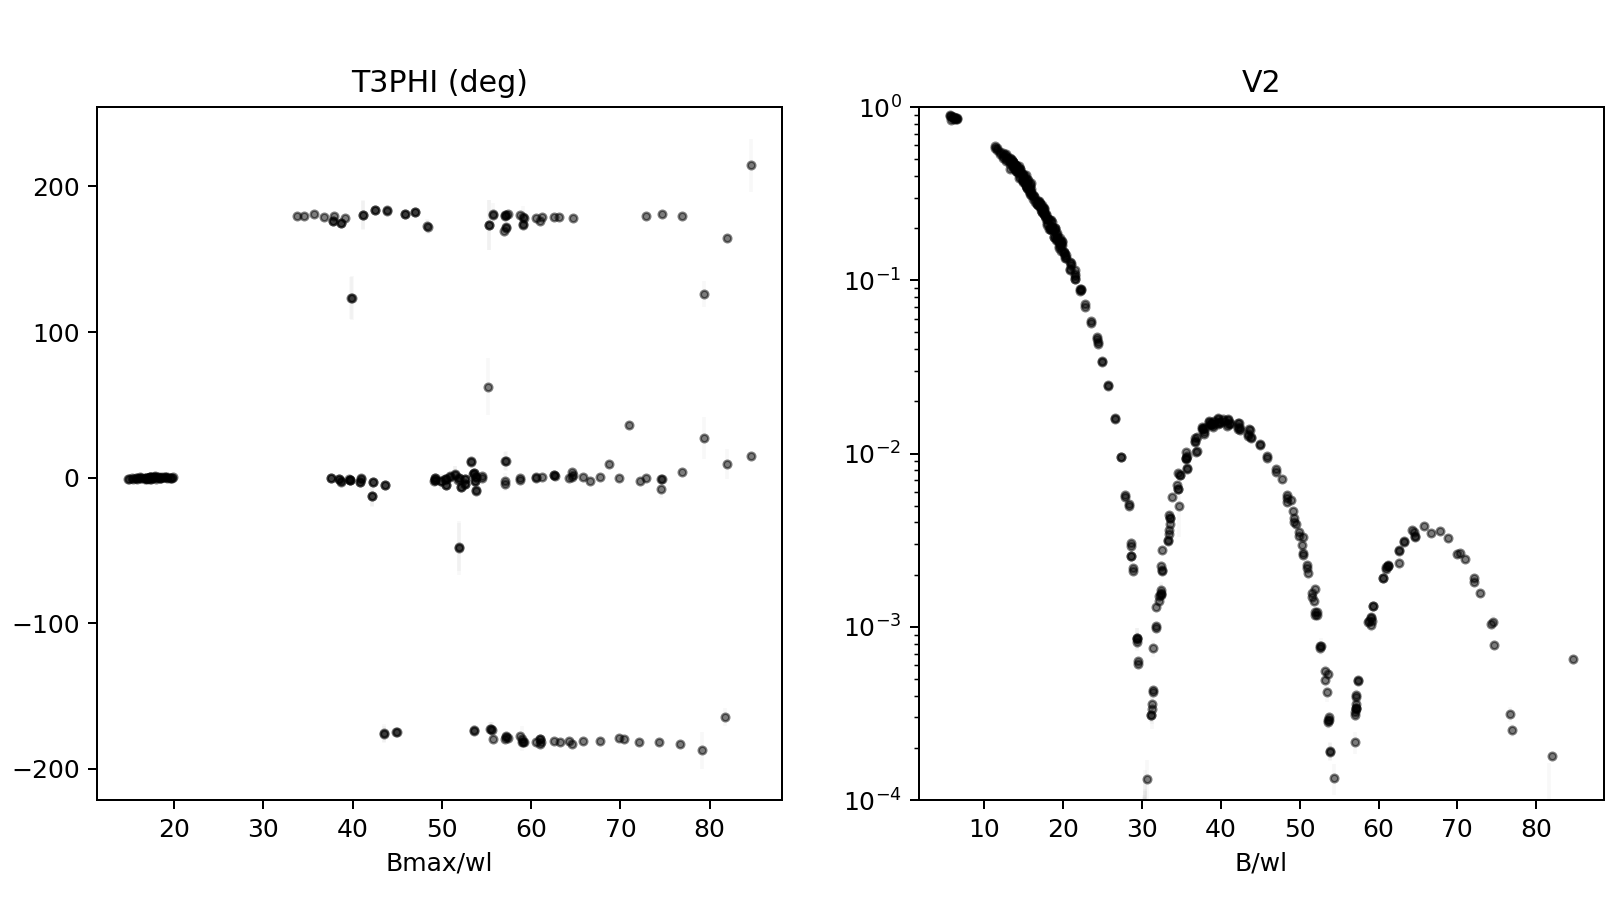

<IPython.core.display.Javascript object>


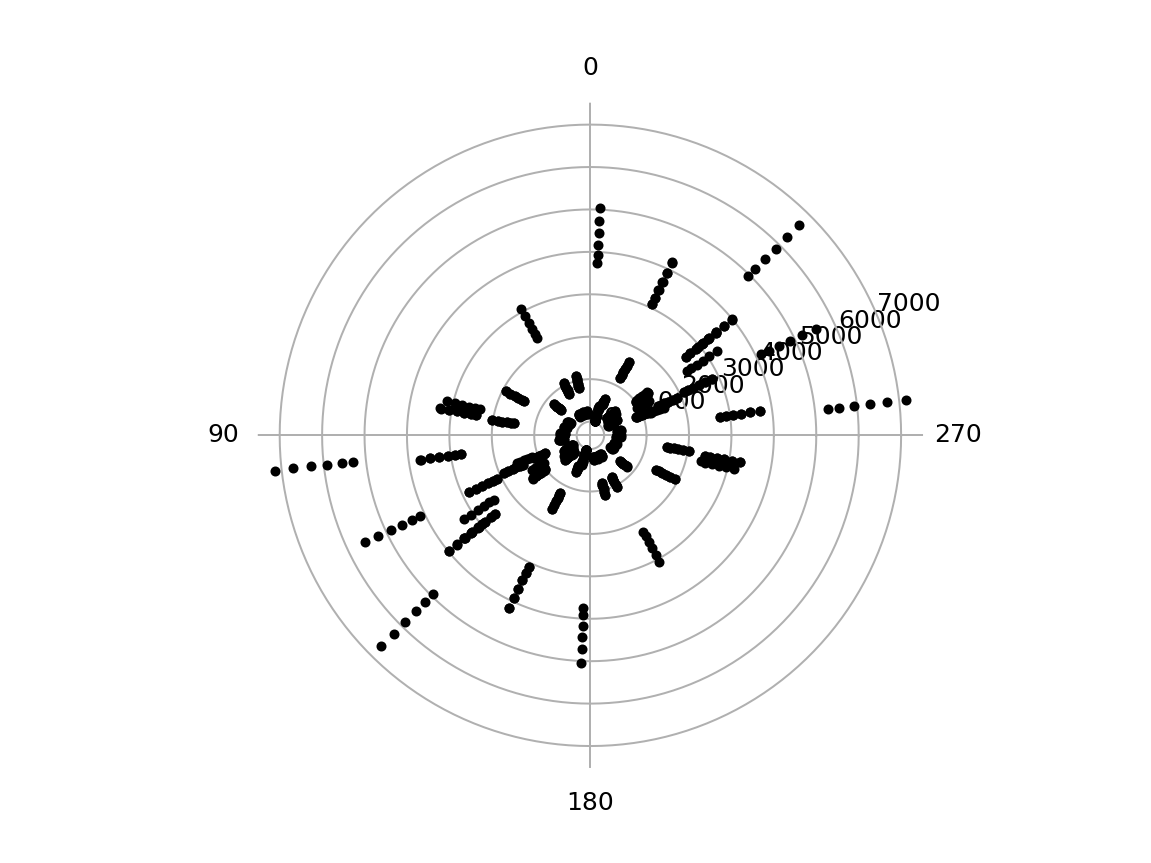

In [3]:
oimodels.showOI(merged, allInOne=1, fig=1, logV=True)
oimodels.showUV(merged, fig=2, polar=True)

## Fit uniform disk model
In order to fit, we need to set up:
- for each data dict `d`, we add a dict  `d['fit']`, a dictionnary itslef, containing the context of the fit:
    - `obs`: the list of observables to take into account, in `['V2', '|V|', 'T3PHI', 'DPHI', 'NFLUX']`. `T3PHI` stands for the closure phase. IN addition, there are specific observables for spectrally dospersed data: `DPHI` differential phase and `NFLUX` the flux, normalised to the continuum.
    - `min error`: a dict to set the minimum error (overrinding what's in the data file) for each observable. e.g. `d['fit']['min error'] = {'V2':0.04}`
    - `max error`: a dict to set the maximum error (overrinding what's in the data file) for each observable. e.g. `d['fit']['min error'] = {'V2':0.1}`
    - `wl ranges`: list of ranges ($\lambda_{min}[\mu m]$, $\lambda_{max}[\mu m]$) to restrict fit. e.g. `d['fit']['wl ranges'] = [(1.6, 1.9), (2.2, 2.3)]`. Especially useful for spectral data, to restric fit around a single line
- First guess parameters for the model. The parameters, sotred in a dictionnary, define the model. For example, a uniform disk of 8 milli-ardsecond in diameter is  `{'ud':8.0}`

The fitting function, `oimodels.fitOI` takes the data and first guess. The result is a dict containing (among other things):
- `best`: the dictionnary of best fit parameters
- `uncer`: the dictionnary of uncertainties for the best fit parameters
- `chi2`: the reduced chi2

[dpfit] 1 FITTED parameters: ['ud']
[dpfit] using scipy.optimize.leastsq
[dpfit] Both actual and predicted relative reductions in the sum of squares
  are at most 0.000100
[dpfit] number of function call: 9
[dpfit] time per function call: 6.528 (ms)
------------------------------
        CHI2= 8050.583213774883
REDUCED CHI2= 18.5497309073154
------------------------------
(uncertainty normalized to data dispersion)

{'ud': 8.2988, # +/- 0.0038
}


<IPython.core.display.Javascript object>


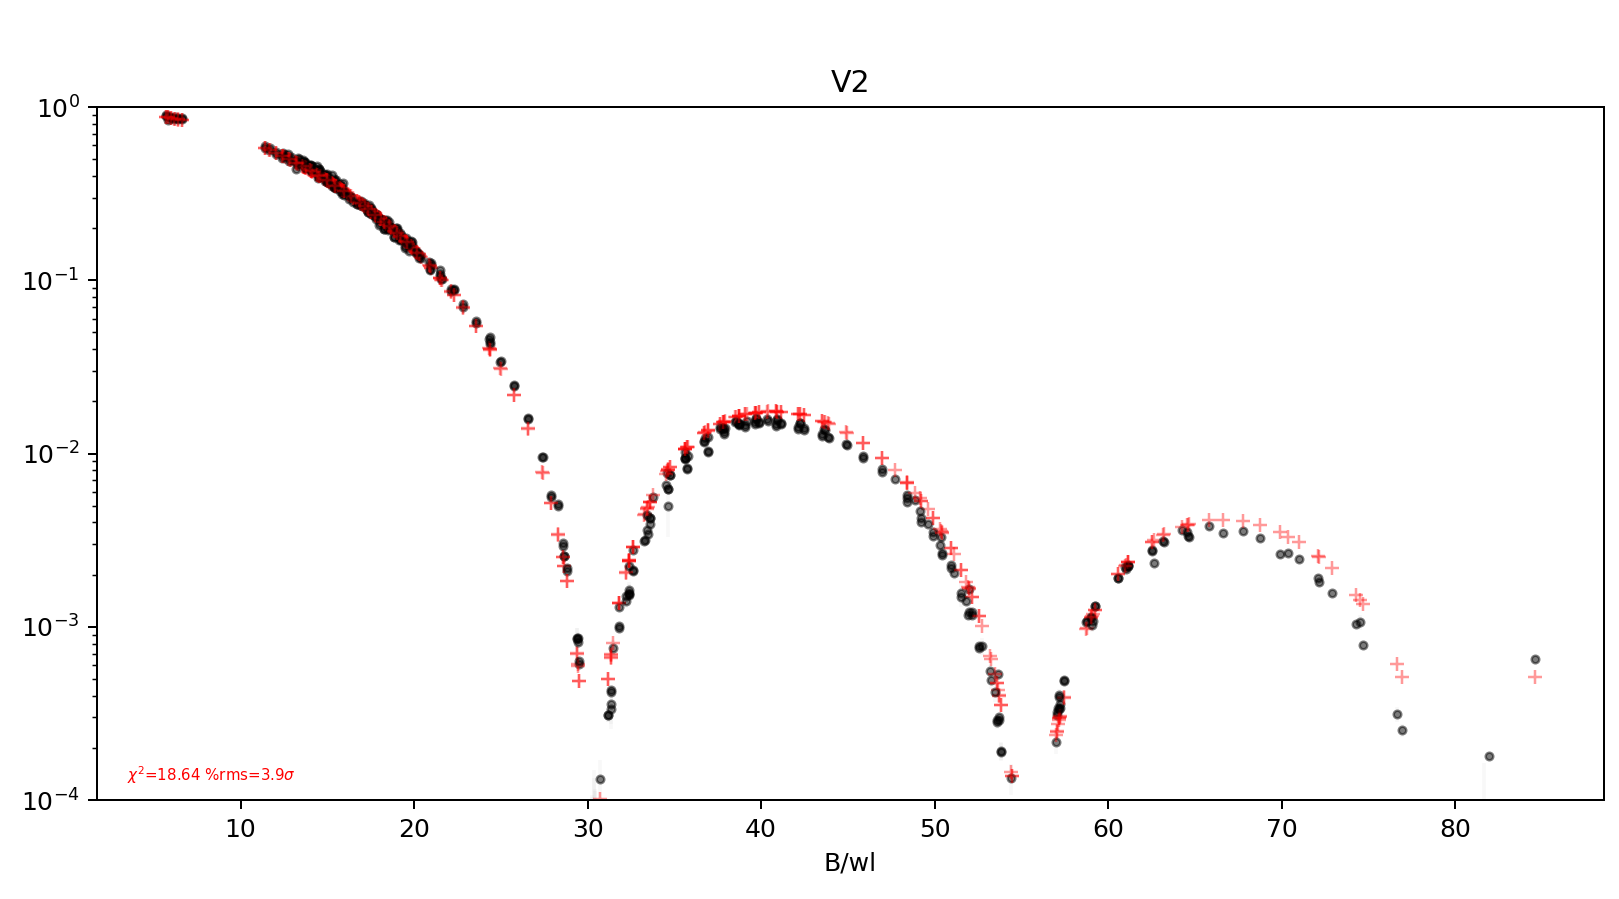

In [4]:
# -- prepare the fit, for each data file, one need to set what observable to fit
# -- can be a combination of 'V2', '|V|', 'T3PHI', 'DPHI' (differential phase) or NFLUX (normalize spectra)
for d in merged:
    d['fit'] = {'obs':['V2',]}
    
param = {'ud':8.0, }
fitUD = oimodels.fitOI(merged, param)
oimodels.showOI(merged, fitUD['best'], allInOne=1, fig=3, logV=True, color='red', showChi2=1)

## Fit a diameter with fixed Claret 4-parameters center-to-limb darkening
From Kervalla et al. A&A 597, 137 (2017), table 3:
- paper: https://ui.adsabs.harvard.edu/abs/2017A%26A...597A.137K/abstract
- table 3: https://www.aanda.org/articles/aa/full_html/2017/01/aa29505-16/T3.html

In this example, we use an arbitrary profile for the center-to-limb darkening. `d['fit']` need an additional entry, `Nr` the number of data points for the numerical Hankel transform. The `profile` for the model uses special syntax with `R` and `MU` for the reduced radius (0..1) and its cosine.  

[dpfit] 1 FITTED parameters: ['diam']
[dpfit] using scipy.optimize.leastsq
[dpfit] Both actual and predicted relative reductions in the sum of squares
  are at most 0.000100
[dpfit] number of function call: 13
[dpfit] time per function call: 32.17 (ms)
------------------------------
        CHI2= 2081.4381509373825
REDUCED CHI2= 4.795940439947886
------------------------------
(uncertainty normalized to data dispersion)

{'diam':    8.5033, # +/- 0.0023
'profile': '1 - .7127*(1-MU**0.5) + 0.0452*(1-MU) + 0.2643*(1-MU**1.5) - 0.1311*(1-MU**2)' ,
}


<IPython.core.display.Javascript object>


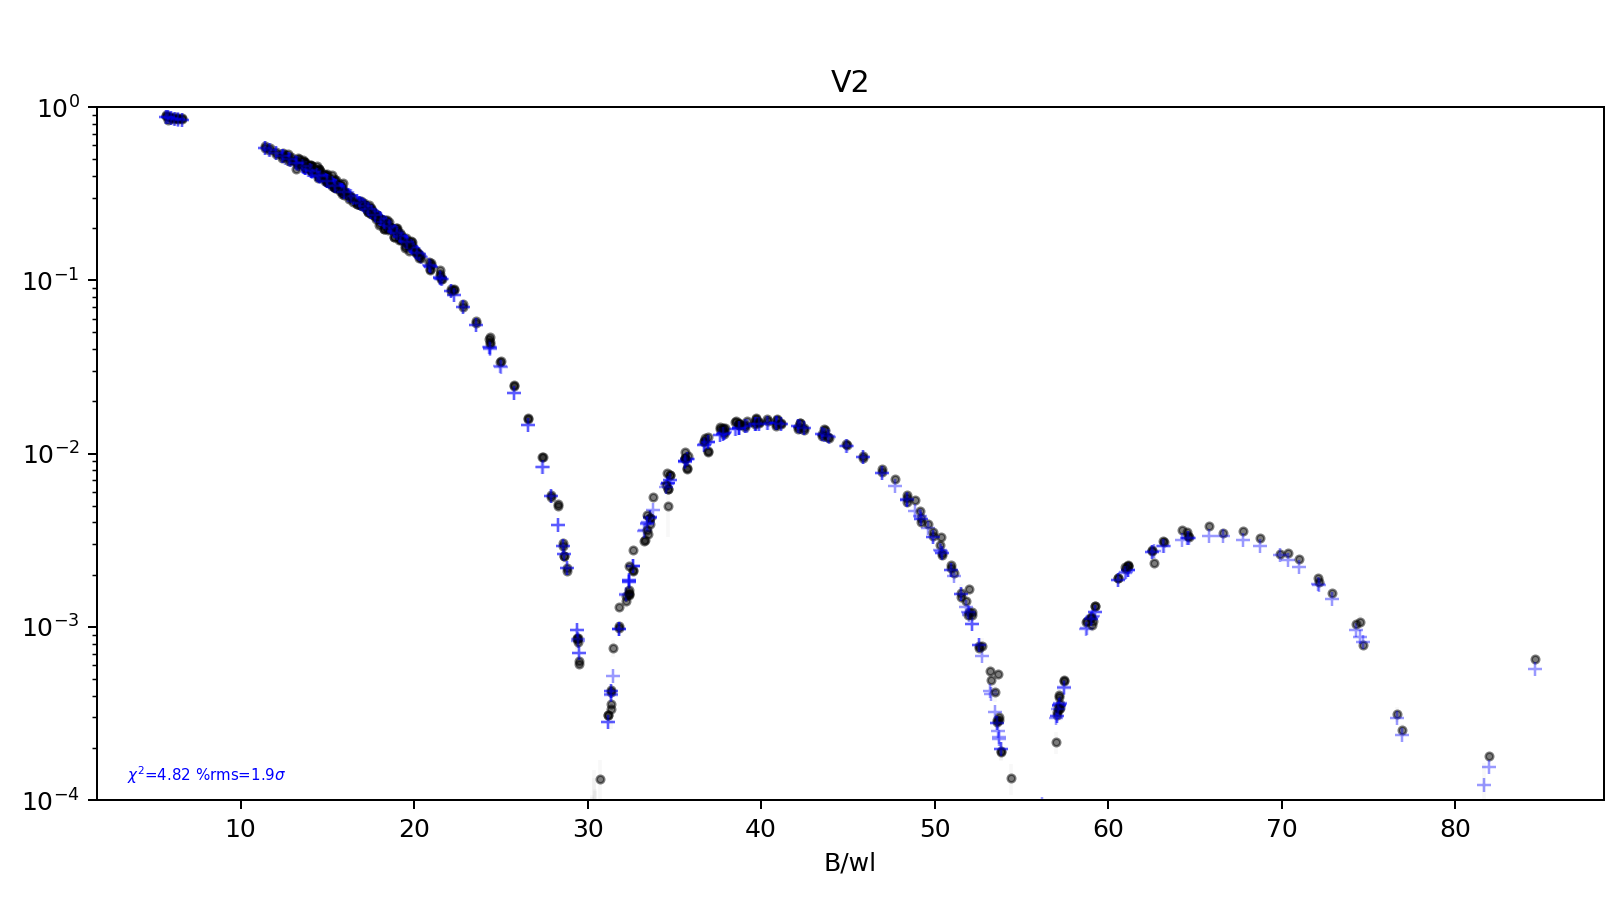

In [5]:
for d in merged:
    # -- only fit V2 and set the numbers of radial points for the computation of the intensity profile
    d['fit'] = {'obs':['V2',], 'Nr':100}

# -- first guess with Claret 4 parameters model
param = {'diam':8., 'profile':'1 - .7127*(1-MU**0.5) + 0.0452*(1-MU) + 0.2643*(1-MU**1.5) - 0.1311*(1-MU**2)'}
fitC4 = oimodels.fitOI(merged, param)
oimodels.showOI(merged, fitC4['best'], allInOne=1, fig=4, logV=True, color='blue')

## Fit a power law center-to-limb darkening
Both diameter and power law index `alpha` are fitted. When more than one parameters are fitted, correlations between parameters will be shown, whith colors to indicate the strength of the correlation. In our example below, the correlation is very high. Note that evaluation of `profile` is pretty lazy and sollely bsed on string replacement. Do not both "cos" as a variable and in the profile: `{'cos':.1, 'profile':'cos*np.cos(R)'}` will result in an error since the profile will be interpreted as "0.1*np.0.1(R)"!

[dpfit] 2 FITTED parameters: ['diam', 'alpha']
[dpfit] using scipy.optimize.leastsq
[dpfit] Both actual and predicted relative reductions in the sum of squares
  are at most 0.000100
[dpfit] number of function call: 19
[dpfit] time per function call: 29.47 (ms)
------------------------------
        CHI2= 1886.7830983142837
REDUCED CHI2= 4.357466739755852
------------------------------
(uncertainty normalized to data dispersion)

{'alpha':   0.1479, # +/- 0.0043
'diam':    8.4980, # +/- 0.0052
'profile': 'MU**alpha' ,
}
Correlations  >=.9 >=.8 >=.7 >=.5 >=.2 <.2
            0    1  
  0: diam ####  .91 
  1:alpha  .91 #### 


<IPython.core.display.Javascript object>


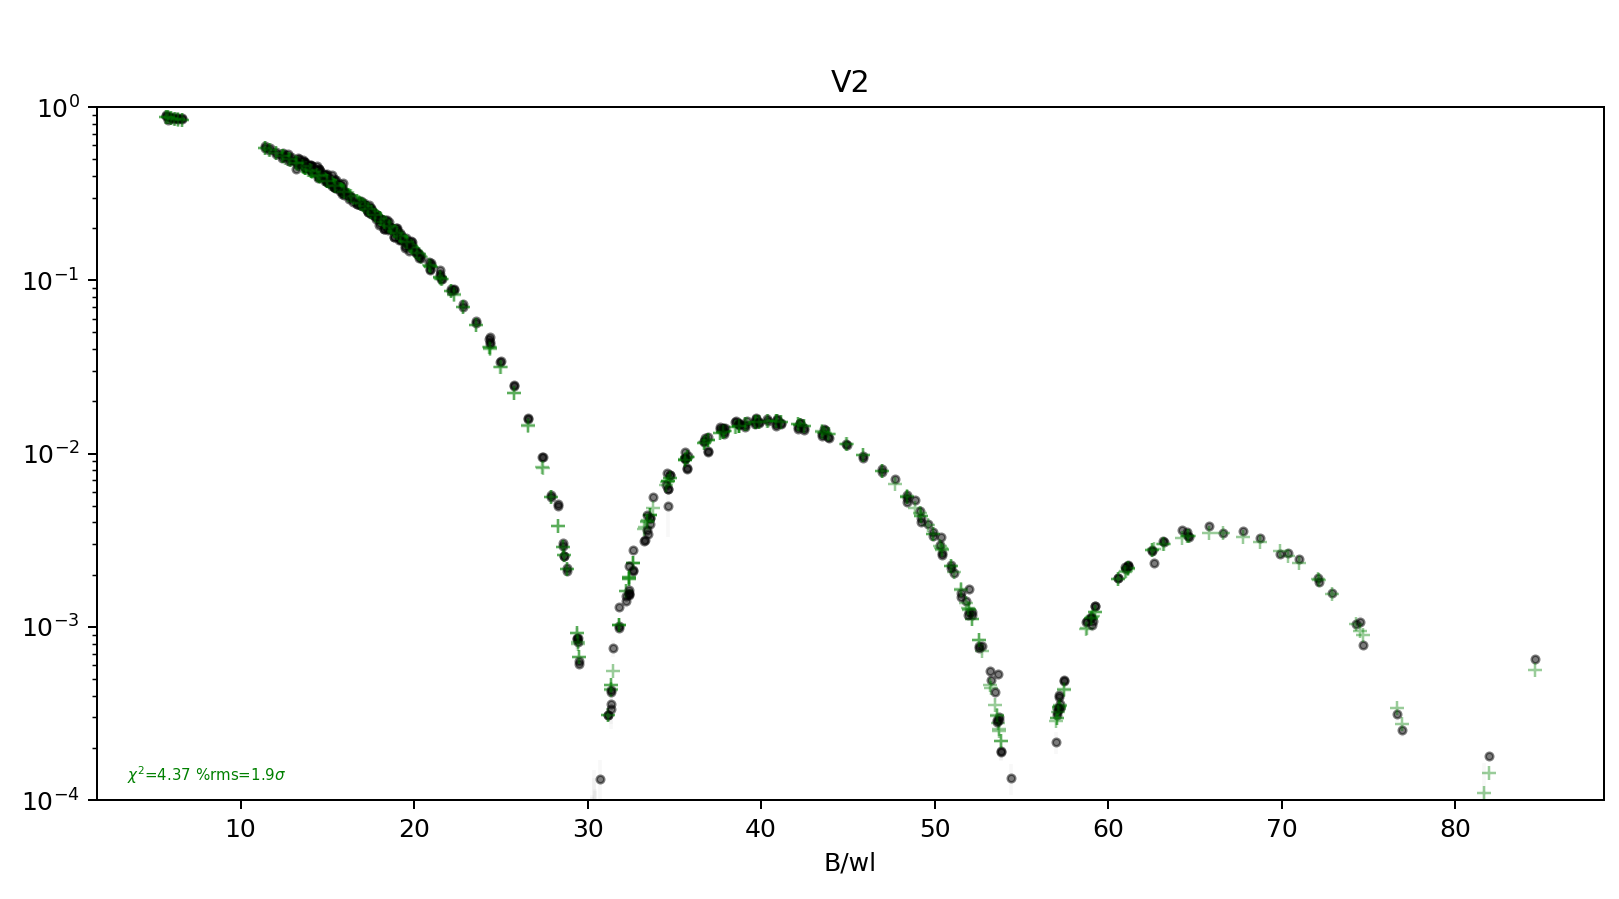

In [6]:
# -- prepare the fit, for each data file, one need to set what observable to fit
# -- can be a combination of 'V2', '|V|', 'T3PHI', 'DPHI' (differential phase) or NFLUX (normalize spectra)
for d in merged:
    d['fit'] = {'obs':['V2',], 'Nr':100}
    
param = {'diam':8.0, 'profile':'MU**alpha', 'alpha':1.0}
fitAlpha = oimodels.fitOI(merged, param)
oimodels.showOI(merged, fitAlpha['best'], allInOne=1, fig=5, logV=True, color='green')

## Bootstrapping for better estimate of uncertainties
The reduced $\chi^2$ of fits are large. This seems to indicate that errors in data are understimated, or that our model is inadequate. The V2 plot seem to indicate that our model is pretty good. The overall reduced $\chi^2$ is not used in the parameters' uncertainties estimation. Rather, `OIUTILS` use the convention that uncertainties are scaled to the data scatter. 

Another way to estimate uncertainties is to bootstrap on the data and do multiple fits to estimate the scatter of the fitted parameters. It is achieved by drawing data randomly to create new data sets. The final parameters and uncertainties are estimated as the average and standard devitation of all the fits which were performed.

The default number of bootstrapped fit is 2xnumber of data, where the atomic data is a spectral vector of V2, |V|, T3PHI etc. You can set this by hand using `N=` keyword in `oimodels.bootstrapFitOI`. To accelerate the computation, it is parallelized. `oimodels.bootstrapFitOI` can take an additional parameter, `multi=`, to set the number of threads in case you do not wish to swamp your CPU with too much activity.

The bootstrap fits are filtered using a recursive sigma clipping algorithm. You can re-run the analysis (without recomputing all the fits), by using `oimodels.analyseBootstrap` with option `sigmaClipping` (default is 4.5). When more than one parameter is explored, covariance is computed from the 2D scatter plot. `oimodels.showBootstrap` shows the scatter plots and histograms, as well as as comparison with the fit to all data and its uncertainties.

In [7]:
bootAlpha = oimodels.bootstrapFitOI(merged, fitAlpha)

pooling 4 processes to run 144 fits...
one fit takes ~1.08s
it took 93.1s, 0.66s per fit on average
using 144 fits out of 144 (sigma clipping 4.50)
{'alpha'  : 0.1472, # +/- 0.0057
'diam'   : 8.4972, # +/- 0.0058
'profile': MU**alpha
}
Correlations  >=.9 >=.8 >=.7 >=.5 >=.2 <.2
            0    1  
  0: diam ####  .83 
  1:alpha  .83 #### 


<IPython.core.display.Javascript object>


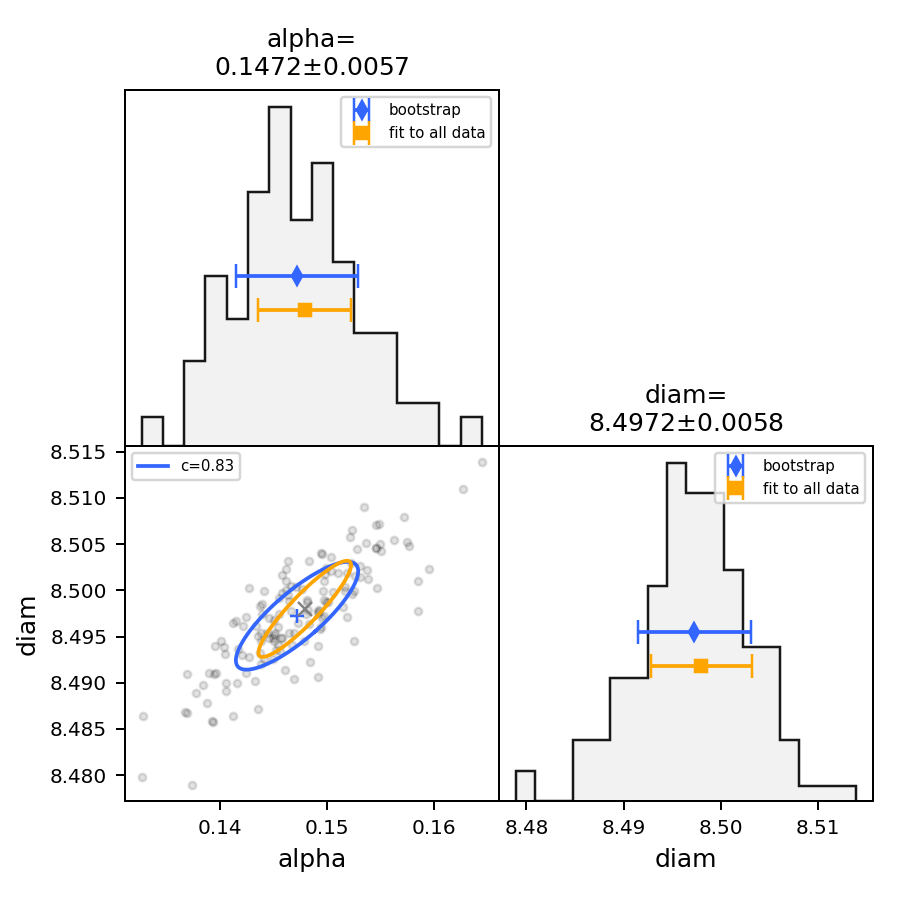

In [8]:
oimodels.showBootstrap(bootAlpha, fig=6)